In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from numpy import cos
from math import log
from scipy.interpolate import interp1d
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import minimize_scalar
from scipy.optimize import minimize
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from sage.plot.plot3d.parametric_surface import ParametricSurface
import plotly.graph_objects as go
import plotly.express as px
from scipy.optimize import fsolve
from sympy import symbols, Eq, solve

In [2]:
def population_dynamics_model(t, z, T_prime, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                               B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                               D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
                               N, M, E_M0, I_H0, I_M0, R_H0, mu_H, k):
    
    S_H, I_H, R_H, S_M, E_M, I_M = z
    
    # Temperature and rainfall functions
    def Temp(t):
        return T1 * (1 + T2 * cos(omega1 * t - phi1))

    def Rain(t):
        return R1 * (1 + R2 * cos(omega2 * t - phi2))

    R_curr = Rain(t)
    T_curr = Temp(t)
    
    # Larval development duration
    def tau_L(Temp):
        return 1 / (c1 * Temp + c2)
    
    # Daily mosquito survival rate
    def p(Temp):
        return np.exp(-1 / (A * Temp**2 + B * Temp + C))
    
    # Larval survival probability dependent on temperature and rainfall
    def p_LT(Temp):
        return np.exp(-(c1 * Temp + c2))
    
    def p_LR(Rain):
        return (4 * p_ML / R_L**2) * Rain * (max(1e-5, R_L - Rain))
    
    def p_LRT(Rain, Temp):
        return p_LR(Rain) * p_LT(Temp)
    
    # Egg and pupa survival probability dependent on rainfall 
    def p_ER(Rain):
        return (4 * p_ME / R_L**2) * Rain * (max(1e-5, R_L - Rain))
    
    # Pupa survival probability dependent on rainfall 
    def p_PR(Rain):
        return (4 * p_MP / R_L**2) * Rain * (max(1e-5, R_L - Rain))

    # Sporogonic cycle duration
    def tau_M(Temp):
        return DD / (max(1e-5, Temp - Tmin))
    
    tau_M_curr = tau_M(T_curr)

    # Exposed-to-infected rate (1/Sporogonic cycle duration)
    def b3(tau_M, Temp):
        return 1 / tau_M
    
    b3_curr = b3(tau_M_curr, T_curr)
    
    # Defining the mosquito survival function
    def l_tau_M(tau_M, Temp):  
        p_T = p(Temp)
        return p_T**tau_M
    
    l_curr = l_tau_M(tau_M_curr, T_curr)

    # Mosquito mortality rate
    def mu(Temp):
        return -log(p(Temp))
    
    mu_curr = mu(T_curr)
    
    # Calculate biting rate and transmission probability
    def a(Temp):
        return max(1e-5, (Temp - T_prime) / D1)
    
    a_curr = a(T_curr)
    
    def b(Rain, Temp):
        return B_E * p_ER(Rain) * p_LRT(Rain, Temp) * p_PR(Rain) / (tau_E + tau_L(Temp) + tau_P)
    
    b_curr = b(R_curr, T_curr)
    
    dShdt = mu_H * N - a_curr * k * b2 * (I_M / N) * S_H - mu_H * S_H
    dIhdt = a_curr * k * b2 * (I_M / N) * S_H - gamma * I_H - mu_H * I_H
    dRhdt = gamma * I_H - mu_H * R_H
    
    dSmdt = b_curr - a_curr * k * b1 * (I_H / N) * S_M - mu_curr * S_M
    dEmdt = a_curr * k * b1 * (I_H / N) * S_M - mu_curr * E_M - b3_curr * E_M - l_curr * E_M
    dImdt = b3_curr * E_M - mu_curr * I_M
    
    return [dShdt, dIhdt, dRhdt, dSmdt, dEmdt, dImdt] 

In [3]:
T_prime=25.6

T1= 26.4 
T2= 0.025
omega1= 0.017
phi1= -1.45

R1= 250.083 
R2= 0.565
omega2= 0.02
phi2=1.6

B_E=200
p_ME=0.9
p_ML=0.25
p_MP=0.75
tau_E=1
tau_P=1
c1=0.00554
c2=-0.06737
D1=36.5
b1=0.04

A=12.5
B=15
C=-48.78

mu_H=0.00007
k=1

b2=0.09
tau_H=10
DD=105
Tmin=14.5
gamma=1/120
R_L=450
N=7717
M=300000  #0

E_M0=1
I_M0=0 # None
I_H0=1
R_H0=0

if E_M0 is None:
        E_M0 = M / 100

S_H0 = N - I_H0 - R_H0
S_M0 = M - E_M0 - I_M0

#### Calculating $I_H^*$:

In [4]:
def equilibrium_numerator_IH(N, mu, b3, l, mu_H, a, b, b1, b2, k, gamma):
    return (N**2 * mu**3 + (N**2 * b3 + N**2 * l)*mu**2)*mu_H**2 - (N * a**2 * b * b1 * b2 * b3 * k**2 - N**2 * gamma * mu**3 - (N**2 * b3 * gamma + N**2 * gamma * l) * mu**2) * mu_H
     
    
def equilibrium_denominator_IH(N, mu, b3, l, mu_H, a, b, b1, b2, k, gamma):
    return a**2 * b * b1 * b2 * b3 * gamma * k**2 + (N * a * b1 * k * mu**2 + (N * a * b1 * b3 * k + N * a * b1 * k * l)*mu)*mu_H**2 + (a**2 * b * b1 * b2 * b3 * k**2 + N * a * b1 * gamma * k * mu**2 + (N * a * b1 * b3 * gamma * k + N * a * b1 * gamma * k * l)*mu)*mu_H
    
    
def equilibrium_IH(N, mu, b3, l, mu_H, a, b, b1, b2, k, gamma):
    return -1*equilibrium_numerator_IH(N, mu, b3, l, mu_H, a, b, b1, b2, k, gamma) / equilibrium_denominator_IH(N, mu, b3, l, mu_H, a, b, b1, b2, k, gamma)
 
def calculate_equilibrium_final_values_IH(N, R_L, T_prime, Tmin, DD, D1, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                            p_ML, p_ME, p_MP, c1, c2, A, B, C, b1, b2, gamma, mu_H, k):
    
    Tf = T1 * (1 + T2 * cos(omega1 * 1825 - phi1))
    Rf = R1 * (1 + R2 * cos(omega2 * 1825 - phi2))

    tau_Lf = 1 / (c1 * Tf + c2)

    p_LTf = np.exp(-(c1 * Tf + c2))
    
    p_LRf = (4 * p_ML / R_L**2) * Rf * (max(1e-5, R_L - Rf))
    
    p_LRTf = p_LRf * p_LTf
    
    p_ERf = (4 * p_ME / R_L**2) * Rf * (max(1e-5, R_L - Rf))
    
    p_PRf = (4 * p_MP / R_L**2) * Rf * (max(1e-5, R_L - Rf))

    af = (max(1e-5, Tf - T_prime)) / D1
    bf = B_E * p_ERf * p_LRTf * p_PRf / (tau_E + tau_Lf + tau_P)

    tau_Mf = DD / (max(1e-5, Tf - Tmin))
    
    b3f =  1 / tau_Mf
    
    pf = np.exp(-1 / (A * Tf**2 + B * Tf + C))
    lf = pf ** tau_Mf

    muf = -log(pf)

    equilibrium_numerator_final_IH = equilibrium_numerator_IH(N, muf, b3f, lf, mu_H, af, bf, b1, b2, k, gamma)
    equilibrium_denominator_final_IH = equilibrium_denominator_IH(N, muf, b3f, lf, mu_H, af, bf, b1, b2, k, gamma)
    equilibrium_final_IH = equilibrium_IH(N, muf, b3f, lf, mu_H, af, bf, b1, b2, k, gamma)
    
    return equilibrium_numerator_final_IH, equilibrium_denominator_final_IH, equilibrium_final_IH   

In [5]:
def equation_to_solve_equilibrium_IH(k):
    equilibrium_final_IH = calculate_equilibrium_final_values_IH(
        N, R_L, T_prime, Tmin, DD, D1, T1, T2,
        omega1, phi1, R1, R2, omega2, phi2,
        p_ML, p_ME, p_MP, c1, c2, A, B, C,
        b1, b2, gamma, mu_H, k)[2] ## index of the equilibrium in calculate_equilibrium_final_values_IH
    return equilibrium_final_IH

# Use fsolve to find the root (solution)
initial_guess = 0.5 # Choose an initial guess for k
k_solution = fsolve(equation_to_solve_equilibrium_IH, initial_guess)

print(f"The value of k that is the root of I_H is {k_solution[0]}")

The value of k that is the root of I_H is 1.465648854307738


In [6]:
k_values = np.linspace(2.0746963059512207, 10, 100) 

equilibrium_IH_full_values = []

for k_val in k_values:
    equilibrium_numerator_final_IH, equilibrium_denominator_final_IH, equilibrium_final_IH = calculate_equilibrium_final_values_IH(N, R_L, T_prime, Tmin, DD, D1, 
                                                                               T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                                                                               p_ML, p_ME, p_MP, c1, c2, A, B, C, b1, b2, 
                                                                               gamma, mu_H, k=k_val)
    equilibrium_IH_full_values.append(equilibrium_final_IH)

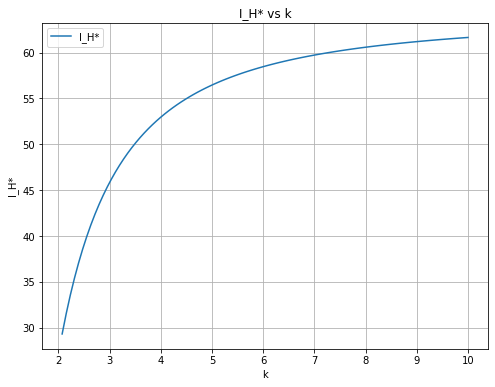

In [7]:
plt.figure(figsize=(8, 6))

plt.plot(k_values, equilibrium_IH_full_values, label='I_H*')
plt.xlabel('k')
plt.ylabel('I_H*')
plt.title('I_H* vs k')

plt.legend()
plt.grid(True)

plt.show() 

In [8]:
k=10

equilibrium_IH_full_values = []

equilibrium_numerator_final_IH, equilibrium_denominator_final_IH, equilibrium_final_IH = calculate_equilibrium_final_values_IH(N, R_L, T_prime, Tmin, DD, D1, 
                                                                               T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                                                                               p_ML, p_ME, p_MP, c1, c2, A, B, C, b1, b2, 
                                                                               gamma, mu_H, k)
equilibrium_IH_full_values.append(equilibrium_final_IH)

In [9]:
equilibrium_IH_full_values

[61.64218051194004]

#### Calculating $S_H^*$:

In [10]:
def equilibrium_numerator_SH(N, mu, b3, l, mu_H, a, b, b1, b2, k, gamma):
    return N**2*gamma*mu**3 + (N**2*b3*gamma + N**2*gamma*l)*mu**2 + (N**2*mu**3 + (N**2*a*b1*k + N**2*b3 + N**2*l)*mu**2 + (N**2*a*b1*b3*k + N**2*a*b1*k*l)*mu)*mu_H
    
def equilibrium_denominator_SH(N, mu, b3, l, mu_H, a, b, b1, b2, k, gamma):
    return a**2*b*b1*b2*b3*k**2 + (N*a*b1*k*mu**2 + (N*a*b1*b3*k+N*a*b1*k*l)*mu)*mu_H
    
def equilibrium_SH(N, mu, b3, l, mu_H, a, b, b1, b2, k, gamma):
    return equilibrium_numerator_SH(N, mu, b3, l, mu_H, a, b, b1, b2, k, gamma) / equilibrium_denominator_SH(N, mu, b3, l, mu_H, a, b, b1, b2, k, gamma)

def calculate_equilibrium_final_values_SH(N, R_L, T_prime, Tmin, DD, D1, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                            p_ML, p_ME, p_MP, c1, c2, A, B, C, b1, b2, gamma, mu_H, k):
    
    Tf = T1 * (1 + T2 * cos(omega1 * 1825 - phi1))
    Rf = R1 * (1 + R2 * cos(omega2 * 1825 - phi2))

    tau_Lf = 1 / (c1 * Tf + c2)

    p_LTf = np.exp(-(c1 * Tf + c2))
    
    p_LRf = (4 * p_ML / R_L**2) * Rf * (max(1e-5, R_L - Rf))
    
    p_LRTf = p_LRf * p_LTf
    
    p_ERf = (4 * p_ME / R_L**2) * Rf * (max(1e-5, R_L - Rf))
    
    p_PRf = (4 * p_MP / R_L**2) * Rf * (max(1e-5, R_L - Rf))

    af = (max(1e-5, Tf - T_prime)) / D1
    bf = B_E * p_ERf * p_LRTf * p_PRf / (tau_E + tau_Lf + tau_P)

    tau_Mf = DD / (max(1e-5, Tf - Tmin))
    
    b3f =  1 / tau_Mf
    
    pf = np.exp(-1 / (A * Tf**2 + B * Tf + C))
    lf = pf ** tau_Mf

    muf = -log(pf)

    equilibrium_numerator_final_SH = equilibrium_numerator_SH(N, muf, b3f, lf, mu_H, af, bf, b1, b2, k, gamma)
    equilibrium_denominator_final_SH = equilibrium_denominator_SH(N, muf, b3f, lf, mu_H, af, bf, b1, b2, k, gamma)
    equilibrium_final_SH = equilibrium_SH(N, muf, b3f, lf, mu_H, af, bf, b1, b2, k, gamma)
    
    return equilibrium_numerator_final_SH, equilibrium_denominator_final_SH, equilibrium_final_SH

In [11]:
def equation_to_solve_equilibrium_SH(k):
    equilibrium_final_SH = calculate_equilibrium_final_values_SH(
        N, R_L, T_prime, Tmin, DD, D1, T1, T2,
        omega1, phi1, R1, R2, omega2, phi2,
        p_ML, p_ME, p_MP, c1, c2, A, B, C,
        b1, b2, gamma, mu_H, k)[2] ## index of the equilibrium in calculate_equilibrium_final_values_SH
    return equilibrium_final_SH

# Use fsolve to find the root (solution)
initial_guess = 0.5 # Choose an initial guess for k
k_solution = fsolve(equation_to_solve_equilibrium_SH, initial_guess)

print(f"The value of k that is the root of S_H is {k_solution[0]}")

The value of k that is the root of S_H is 1.0801588047463911e+82


/opt/sagemath-9.2/local/lib/python3.7/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


In [12]:
k_values = np.linspace(2.0746963059512207, 10, 100) 

equilibrium_SH_full_values = []

for k_val in k_values:
    equilibrium_numerator_final_SH, equilibrium_denominator_final_SH, equilibrium_final_SH = calculate_equilibrium_final_values_SH(N, R_L, T_prime, Tmin, DD, D1, 
                                                                               T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                                                                               p_ML, p_ME, p_MP, c1, c2, A, B, C, b1, b2, 
                                                                               gamma, mu_H, k=k_val)
    equilibrium_SH_full_values.append(equilibrium_final_SH)

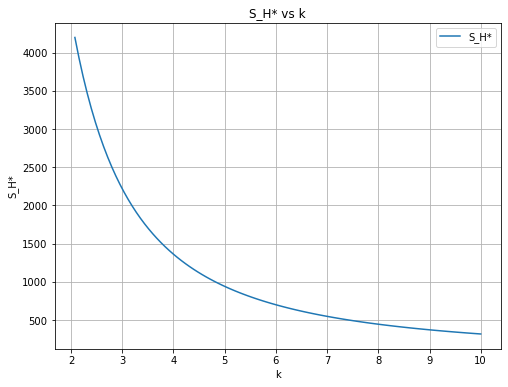

In [13]:
plt.figure(figsize=(8, 6))

plt.plot(k_values, equilibrium_SH_full_values, label='S_H*')
plt.xlabel('k')
plt.ylabel('S_H*')
plt.title('S_H* vs k')

plt.legend()
plt.grid(True)

plt.show() 

In [27]:
k=10

equilibrium_SH_full_values = []

equilibrium_numerator_final_SH, equilibrium_denominator_final_SH, equilibrium_final_SH = calculate_equilibrium_final_values_SH(N, R_L, T_prime, Tmin, DD, D1, 
                                                                               T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                                                                               p_ML, p_ME, p_MP, c1, c2, A, B, C, b1, b2, 
                                                                               gamma, mu_H, k)
equilibrium_SH_full_values.append(equilibrium_final_SH)

In [28]:
equilibrium_SH_full_values

[317.00299663805384]

#### Plotting graphs for each population for multiple values of $k$:

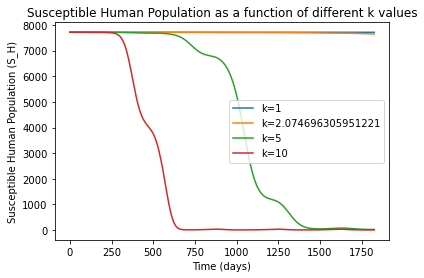

In [30]:
t_eval = np.linspace(0, 1825, 1000)  # Evaluate the solution at 1000 points between 0 and 1825
k_values = [1, 2.0746963059512207, 5, 10]

# Loop over k values
for k_value in k_values:
    # Update k value in the arguments
    args = (T_prime, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
            B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
            D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
            N, M, E_M0, I_H0, I_M0, R_H0, mu_H, k_value)

    # Solve the system of differential equations
    sol = solve_ivp(population_dynamics_model, [0, 1825], [S_H0, I_H0, R_H0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")

    # Extract the results
    times = sol.t
    S_H, I_H, R_H, S_M, E_M, I_M = sol.y

    # Plot S_H as a function of time for the current k value
    plt.plot(times, S_H, label=f'k={k_value}')

# Add labels and title to the plot
plt.xlabel('Time (days)')
plt.ylabel('Susceptible Human Population (S_H)')
plt.title('Susceptible Human Population as a function of different k values')
plt.legend()

# Display the plot
plt.show()

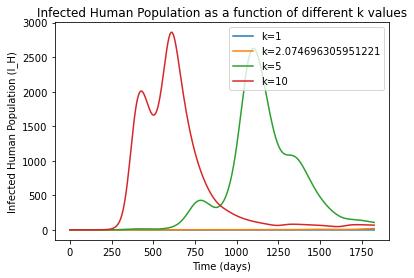

In [31]:
k_values = [1, 2.0746963059512207, 5, 10]

# Loop over k values
for k_value in k_values:
    # Update k value in the arguments
    args = (T_prime, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
            B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
            D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
            N, M, E_M0, I_H0, I_M0, R_H0, mu_H, k_value)

    # Solve the system of differential equations
    sol = solve_ivp(population_dynamics_model, [0, 1825], [S_H0, I_H0, R_H0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")

    # Extract the results
    times = sol.t
    S_H, I_H, R_H, S_M, E_M, I_M = sol.y

    # Plot I_H as a function of time for the current k value
    plt.plot(times, I_H, label=f'k={k_value}')

# Add labels and title to the plot
plt.xlabel('Time (days)')
plt.ylabel('Infected Human Population (I_H)')
plt.title('Infected Human Population as a function of different k values')
plt.legend()

# Display the plot
plt.show()

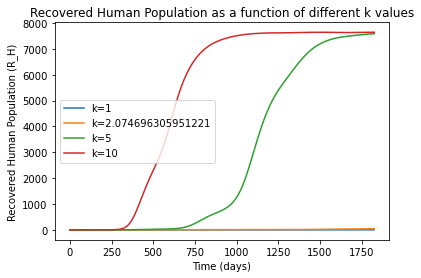

In [32]:
k_values = [1, 2.0746963059512207, 5, 10]

# Loop over k values
for k_value in k_values:
    # Update k value in the arguments
    args = (T_prime, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
            B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
            D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
            N, M, E_M0, I_H0, I_M0, R_H0, mu_H, k_value)

    # Solve the system of differential equations
    sol = solve_ivp(population_dynamics_model, [0, 1825], [S_H0, I_H0, R_H0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")

    # Extract the results
    times = sol.t
    S_H, I_H, R_H, S_M, E_M, I_M = sol.y

    # Plot R_H as a function of time for the current k value
    plt.plot(times, R_H, label=f'k={k_value}')

# Add labels and title to the plot
plt.xlabel('Time (days)')
plt.ylabel('Recovered Human Population (R_H)')
plt.title('Recovered Human Population as a function of different k values')
plt.legend()

# Display the plot
plt.show()

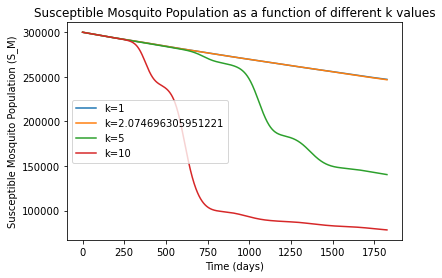

In [33]:
t_eval = np.linspace(0, 1825, 1000)  # Evaluate the solution at 1000 points between 0 and 1825
k_values = [1, 2.0746963059512207, 5, 10]

# Loop over k values
for k_value in k_values:
    # Update k value in the arguments
    args = (T_prime, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
            B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
            D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
            N, M, E_M0, I_H0, I_M0, R_H0, mu_H, k_value)

    # Solve the system of differential equations
    sol = solve_ivp(population_dynamics_model, [0, 1825], [S_H0, I_H0, R_H0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")

    # Extract the results
    times = sol.t
    S_H, I_H, R_H, S_M, E_M, I_M = sol.y

    # Plot S_M as a function of time for the current k value
    plt.plot(times, S_M, label=f'k={k_value}')

# Add labels and title to the plot
plt.xlabel('Time (days)')
plt.ylabel('Susceptible Mosquito Population (S_M)')
plt.title('Susceptible Mosquito Population as a function of different k values')
plt.legend()

# Display the plot
plt.show()

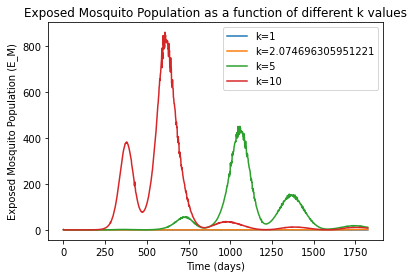

In [35]:
t_eval = np.linspace(0, 1825, 1000)  # Evaluate the solution at 1000 points between 0 and 1825
k_values = [1, 2.0746963059512207, 5, 10]

# Loop over k values
for k_value in k_values:
    # Update k value in the arguments
    args = (T_prime, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
            B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
            D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
            N, M, E_M0, I_H0, I_M0, R_H0, mu_H, k_value)

    # Solve the system of differential equations
    sol = solve_ivp(population_dynamics_model, [0, 1825], [S_H0, I_H0, R_H0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")

    # Extract the results
    times = sol.t
    S_H, I_H, R_H, S_M, E_M, I_M = sol.y

    # Plot E_M as a function of time for the current k value
    plt.plot(times, E_M, label=f'k={k_value}')

# Add labels and title to the plot
plt.xlabel('Time (days)')
plt.ylabel('Exposed Mosquito Population (E_M)')
plt.title('Exposed Mosquito Population as a function of different k values')
plt.legend()

# Display the plot
plt.show()

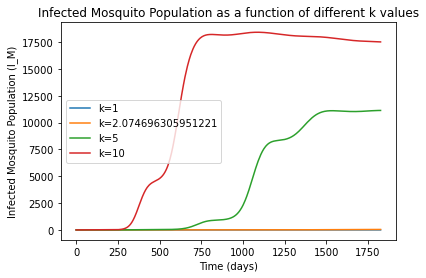

In [36]:
t_eval = np.linspace(0, 1825, 1000)  # Evaluate the solution at 1000 points between 0 and 1825
k_values = [1, 2.0746963059512207, 5, 10]

# Loop over k values
for k_value in k_values:
    # Update k value in the arguments
    args = (T_prime, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
            B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
            D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
            N, M, E_M0, I_H0, I_M0, R_H0, mu_H, k_value)

    # Solve the system of differential equations
    sol = solve_ivp(population_dynamics_model, [0, 1825], [S_H0, I_H0, R_H0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")

    # Extract the results
    times = sol.t
    S_H, I_H, R_H, S_M, E_M, I_M = sol.y

    # Plot I_M as a function of time for the current k value
    plt.plot(times, I_M, label=f'k={k_value}')

# Add labels and title to the plot
plt.xlabel('Time (days)')
plt.ylabel('Infected Mosquito Population (I_M)')
plt.title('Infected Mosquito Population as a function of different k values')
plt.legend()

# Display the plot
plt.show()

#### Performing some sensitivity analysis by plotting trajectories with variations in the initial conditions

In [17]:
k=2.0746963059512207

In [18]:
args = (T_prime, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0, I_M0, R_H0, mu_H, k)

Original trajectory ends at: S_H = 7646.741738370948, I_H = 20.95458224348926
Trajectory 5 ends at: S_H = 271.7265555781892, I_H = 122.93588145344366


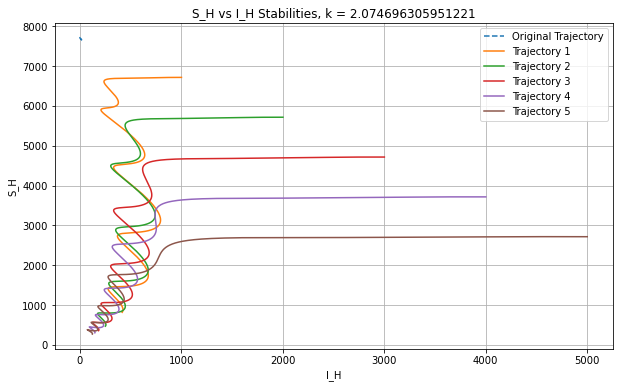

In [19]:
t_span = (0, 1825)

# Initial conditions
initial_conditions = [S_H0, I_H0, R_H0, S_M0, E_M0, I_M0]

# Number of trajectories to analyze
num_trajectories = 5

# Plotting multiple trajectories
plt.figure(figsize=(10, 6))

# Solve the original trajectory
original_solution = solve_ivp(population_dynamics_model, t_span, initial_conditions, args=args, method='RK45', dense_output=True)
original_z_values = original_solution.sol(t_eval)
original_SH_last_value = original_z_values[0][-1]
original_IH_last_value = original_z_values[1][-1]

print(f'Original trajectory ends at: S_H = {original_SH_last_value}, I_H = {original_IH_last_value}')

plt.plot(original_z_values[1], original_z_values[0], label='Original Trajectory', linestyle='--')    

for i in range(num_trajectories):
    
    initial_conditions[0] -= 1000  # Increase the initial number of infected by 1000
    initial_conditions[1] += 1000
    solution = solve_ivp(population_dynamics_model, t_span, initial_conditions, args=args, method='RK45', dense_output=True)
    
    # Extract the results
    t_values = np.linspace(t_span[0], t_span[1], 1000)
    z_values = solution.sol(t_eval)
    
    if i == 4:  # Print the values of the last trajectory
        SH_last_value = z_values[0][-1]
        IH_last_value = z_values[1][-1]
        print(f'Trajectory {i+1} ends at: S_H = {SH_last_value}, I_H = {IH_last_value}')

    # Plot S_H vs I_H for each trajectory
    plt.plot(z_values[1], z_values[0], label=f'Trajectory {i+1}')
    
plt.title(f'S_H vs I_H Stabilities, k = {k}')
plt.xlabel('I_H')
plt.ylabel('S_H')
plt.legend()
plt.grid(True)
plt.show()

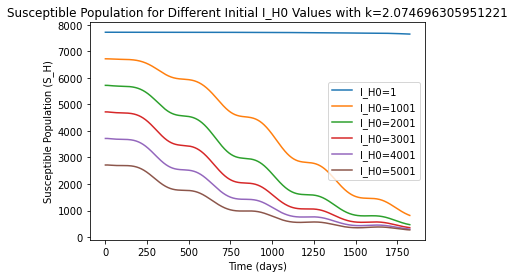

In [20]:
initial_I_H0_values = [1, 1001, 2001, 3001, 4001, 5001]

# Loop over the initial values of I_H0
for initial_I_H0_value in initial_I_H0_values:
    # Update the value of I_H0 in the arguments
    args = (T_prime, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
            B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
            D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
            N, M, E_M0, initial_I_H0_value, I_M0, R_H0, mu_H, k)

    # Solve the system of differential equations
    sol = solve_ivp(population_dynamics_model, [0, 1825], [N - initial_I_H0_value, initial_I_H0_value, R_H0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")

    # Extract the results
    times = sol.t
    S_H, I_H, R_H, S_M, E_M, I_M = sol.y

    # Plot I_H over time for the current value of initial_I_H0
    plt.plot(times, S_H, label=f'I_H0={initial_I_H0_value}')

# Add labels and title to the graph
plt.xlabel('Time (days)')
plt.ylabel('Susceptible Population (S_H)')
plt.title(f'Susceptible Population for Different Initial I_H0 Values with k={k}')
plt.legend()

# Show the graph
plt.show()

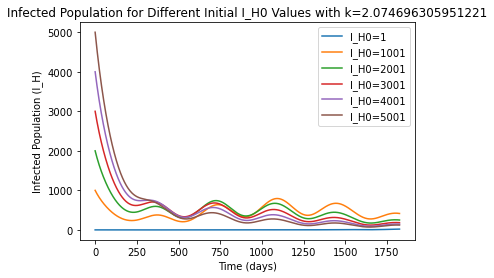

In [21]:
# Loop over the initial values of I_H0
for initial_I_H0_value in initial_I_H0_values:
    # Update the value of I_H0 in the arguments
    args = (T_prime, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
            B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
            D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
            N, M, E_M0, initial_I_H0_value, I_M0, R_H0, mu_H, k)

    # Solve the system of differential equations
    sol = solve_ivp(population_dynamics_model, [0, 1825], [N - initial_I_H0_value, initial_I_H0_value, R_H0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")

    # Extract the results
    times = sol.t
    S_H, I_H, R_H, S_M, E_M, I_M = sol.y

    # Plot I_H over time for the current value of initial_I_H0
    plt.plot(times, I_H, label=f'I_H0={initial_I_H0_value}')

# Add labels and title to the graph
plt.xlabel('Time (days)')
plt.ylabel('Infected Population (I_H)')
plt.title(f'Infected Population for Different Initial I_H0 Values with k={k}')
plt.legend()

# Show the graph
plt.show()

In [22]:
k=10

In [23]:
args = (T_prime, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0, I_M0, R_H0, mu_H, k)

Original trajectory ends at: S_H = 7.811324971445227, I_H = 69.03045254570682
Trajectory 5 ends at: S_H = 8.63319175798149, I_H = 69.44369193283892


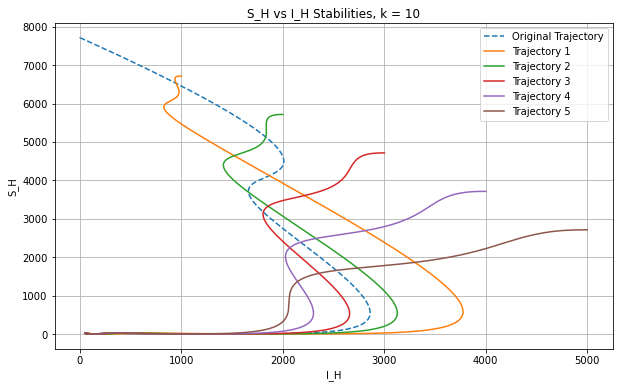

In [24]:
t_span = (0, 1825)

# Initial conditions
initial_conditions = [S_H0, I_H0, R_H0, S_M0, E_M0, I_M0]

# Number of trajectories to analyze
num_trajectories = 5

# Plotting multiple trajectories
plt.figure(figsize=(10, 6))

# Solve the original trajectory
original_solution = solve_ivp(population_dynamics_model, t_span, initial_conditions, args=args, method='RK45', dense_output=True)
original_z_values = original_solution.sol(t_eval)
original_SH_last_value = original_z_values[0][-1]
original_IH_last_value = original_z_values[1][-1]

print(f'Original trajectory ends at: S_H = {original_SH_last_value}, I_H = {original_IH_last_value}')

plt.plot(original_z_values[1], original_z_values[0], label='Original Trajectory', linestyle='--')    

for i in range(num_trajectories):
    
    initial_conditions[0] -= 1000  # Increase the initial number of infected by 1000
    initial_conditions[1] += 1000
    solution = solve_ivp(population_dynamics_model, t_span, initial_conditions, args=args, method='RK45', dense_output=True)
    
    # Extract the results
    t_values = np.linspace(t_span[0], t_span[1], 1000)
    z_values = solution.sol(t_eval)
    
    if i == 4:  # Print the values of the last trajectory
        SH_last_value = z_values[0][-1]
        IH_last_value = z_values[1][-1]
        print(f'Trajectory {i+1} ends at: S_H = {SH_last_value}, I_H = {IH_last_value}')

    # Plot S_H vs I_H for each trajectory
    plt.plot(z_values[1], z_values[0], label=f'Trajectory {i+1}')
    
plt.title(f'S_H vs I_H Stabilities, k = {k}')
plt.xlabel('I_H')
plt.ylabel('S_H')
plt.legend()
plt.grid(True)
plt.show()

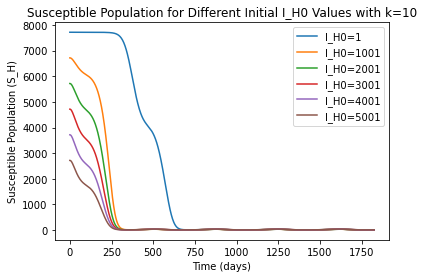

In [25]:
# Loop over the initial values of I_H0
for initial_I_H0_value in initial_I_H0_values:
    # Update the value of I_H0 in the arguments
    args = (T_prime, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
            B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
            D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
            N, M, E_M0, initial_I_H0_value, I_M0, R_H0, mu_H, k)

    # Solve the system of differential equations
    sol = solve_ivp(population_dynamics_model, [0, 1825], [N - initial_I_H0_value, initial_I_H0_value, R_H0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")

    # Extract the results
    times = sol.t
    S_H, I_H, R_H, S_M, E_M, I_M = sol.y

    # Plot I_H over time for the current value of initial_I_H0
    plt.plot(times, S_H, label=f'I_H0={initial_I_H0_value}')

# Add labels and title to the graph
plt.xlabel('Time (days)')
plt.ylabel('Susceptible Population (S_H)')
plt.title(f'Susceptible Population for Different Initial I_H0 Values with k={k}')
plt.legend()

# Show the graph
plt.show()

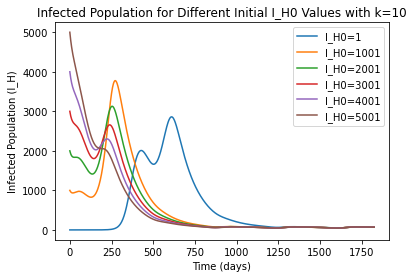

In [26]:
# Loop over the initial values of I_H0
for initial_I_H0_value in initial_I_H0_values:
    # Update the value of I_H0 in the arguments
    args = (T_prime, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
            B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
            D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
            N, M, E_M0, initial_I_H0_value, I_M0, R_H0, mu_H, k)

    # Solve the system of differential equations
    sol = solve_ivp(population_dynamics_model, [0, 1825], [N - initial_I_H0_value, initial_I_H0_value, R_H0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")

    # Extract the results
    times = sol.t
    S_H, I_H, R_H, S_M, E_M, I_M = sol.y

    # Plot I_H over time for the current value of initial_I_H0
    plt.plot(times, I_H, label=f'I_H0={initial_I_H0_value}')

# Add labels and title to the graph
plt.xlabel('Time (days)')
plt.ylabel('Infected Population (I_H)')
plt.title(f'Infected Population for Different Initial I_H0 Values with k={k}')
plt.legend()

# Show the graph
plt.show()